In [11]:
import os

import numpy
import pyextremes
import pandas
import scipy
import seaborn
import xarray

from knn import knn

%matplotlib inline

In [30]:
workspace_dir = '../../all_models_experiments'
# bootstrapped_dates_path = os.path.join(workspace_dir, 'intermediate', 'bootstrapped_dates_precip_CanESM5_ssp126.csv')
# historical_data_path = os.path.join(workspace_dir, 'intermediate', 'mswep_mean.nc')
gcm_data_path = os.path.join(workspace_dir, 'intermediate', 'pr_day_CanESM5_ssp126_mean.nc')

In [31]:
# future_data = pandas.read_csv(bootstrapped_dates_path, parse_dates={'date': [0]})
# future_data.set_index('date', inplace=True)
# future_data = future_data['historic_precip']

In [91]:
with xarray.open_dataset(gcm_data_path) as dataset:
    dataset['time'] = dataset.indexes['time'].to_datetimeindex()
    dataset = dataset.sortby('time')
    historical_data = dataset.sel(time=slice('1985-01-01', '2014-12-31')).pr.to_series()
    future_data = dataset.sel(time=slice('2030-01-01', '2060-01-01')).pr.to_series()

C:\Users\dmf\AppData\Local\Temp\ipykernel_11564\2896783927.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dataset['time'] = dataset.indexes['time'].to_datetimeindex()


In [92]:
future_data

time
2030-01-01 12:00:00    0.000139
2030-01-02 12:00:00    0.000089
2030-01-03 12:00:00    0.000081
2030-01-04 12:00:00    0.000171
2030-01-05 12:00:00    0.000087
                         ...   
2059-12-28 12:00:00    0.000080
2059-12-29 12:00:00    0.000118
2059-12-30 12:00:00    0.000080
2059-12-31 12:00:00    0.000111
2060-01-01 12:00:00    0.000090
Name: pr, Length: 10951, dtype: float32

In [103]:
thresholds = [x / 10000 for x in range(0, 7)]

In [104]:
thresholds

[0.0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006]

<AxesSubplot: xlabel='Threshold', ylabel='Mean excess'>

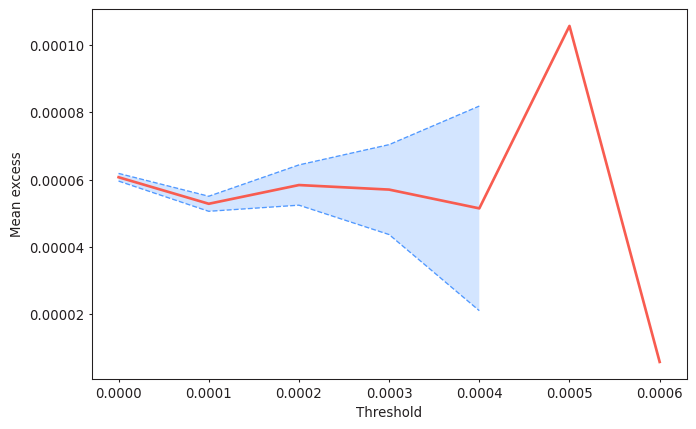

In [105]:
pyextremes.plot_mean_residual_life(historical_data, thresholds=thresholds)

(<AxesSubplot: ylabel='Shape, $\\xi$'>,
 <AxesSubplot: xlabel='Threshold', ylabel='Modified scale, $\\sigma^*$'>)

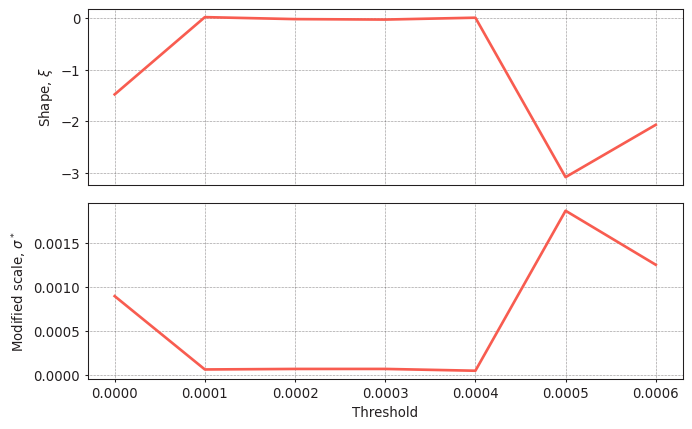

In [106]:
pyextremes.plot_parameter_stability(historical_data, thresholds=thresholds)

In [113]:
threshold = 0.0003
threshold_percentile = sum(historical_data < threshold) / len(historical_data) * 100

In [114]:
threshold_percentile

99.39726027397259

(<Figure size 768x480 with 1 Axes>, <AxesSubplot: xlabel='time', ylabel='pr'>)

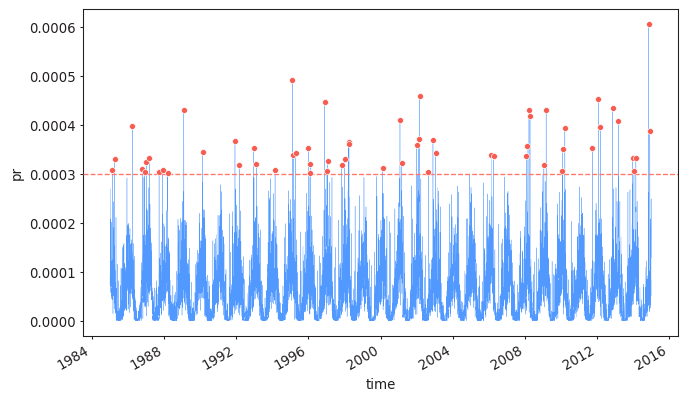

In [115]:
model = pyextremes.EVA(data=historical_data)
model.get_extremes(
    method='POT',
    extremes_type='high',
    threshold=threshold
)
model.plot_extremes()

In [116]:
model.fit_model(distribution='genpareto')
print(model)

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                            pr      Size:                              10,950
Start:                       January 1985      End:                        December 2014
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 60      Extraction method:                    POT
Type:                                high      Threshold:                         0.0003
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

In [117]:
c = model.distribution.mle_parameters['c']
scale = model.distribution.mle_parameters['scale']
loc = model.distribution.fixed_parameters['floc']
historical_sample = scipy.stats.genpareto.rvs(c, loc, scale, size=10000)

(<Figure size 768x480 with 1 Axes>, <AxesSubplot: xlabel='time', ylabel='pr'>)

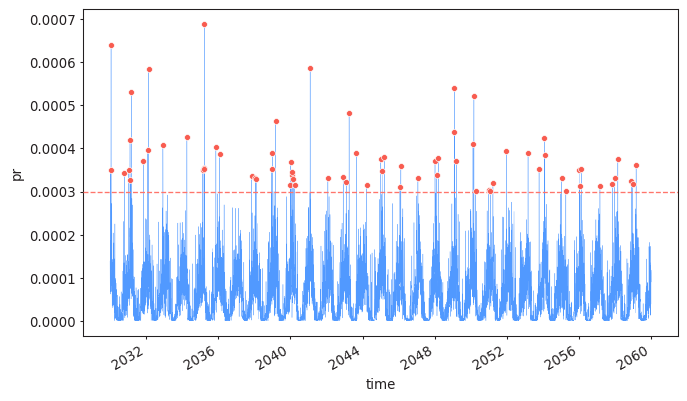

In [120]:
f_model = pyextremes.EVA(data=future_data)
f_model.get_extremes(
    method='POT',
    extremes_type='high',
    threshold=threshold
)
f_model.plot_extremes()

In [122]:
f_model.fit_model(distribution='genpareto')
print(f_model)

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                            pr      Size:                              10,951
Start:                       January 2030      End:                         January 2060
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 72      Extraction method:                    POT
Type:                                high      Threshold:                         0.0003
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

In [125]:
c = f_model.distribution.mle_parameters['c']
scale = f_model.distribution.mle_parameters['scale']
loc = f_model.distribution.fixed_parameters['floc']
future_sample = scipy.stats.genpareto.rvs(c, loc, scale, size=10000)

In [127]:
df = pandas.DataFrame({
    'historic_sample': numpy.sort(historical_sample),
    'future_sample': numpy.sort(future_sample),
})

<AxesSubplot: >

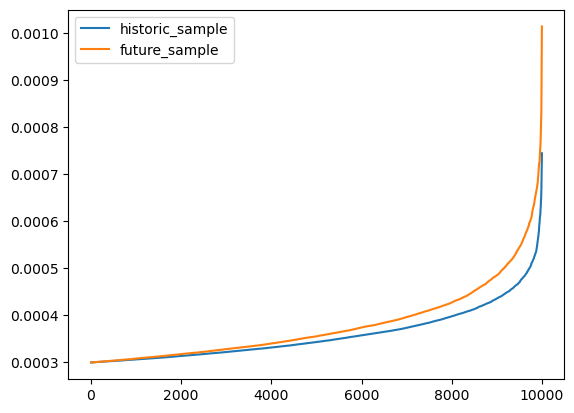

In [128]:
df.plot()

In [138]:
numpy.count_nonzero(df.historic_sample<0.0004) / df.historic_sample.size

0.8069

In [144]:
numpy.count_nonzero(df.historic_sample<0.0004)

8069

In [145]:
df.historic_sample[8069]

0.0004000346681469158

In [147]:
delta = df.future_sample[8069] - df.historic_sample[8069]
print(delta)

3.069548238088943e-05


In [143]:
numpy.array([True, True, False]).mean()

0.6666666666666666

In [134]:
numpy.quantile(df.historic_sample, q=[x / 100 for x in range(0, 100)])

array([0.00030002, 0.00030065, 0.00030129, 0.00030202, 0.00030265,
       0.00030323, 0.00030381, 0.00030445, 0.00030524, 0.00030579,
       0.00030633, 0.00030695, 0.00030759, 0.00030825, 0.00030898,
       0.00030971, 0.00031061, 0.0003114 , 0.00031223, 0.00031299,
       0.00031383, 0.00031466, 0.00031552, 0.0003163 , 0.0003171 ,
       0.00031792, 0.00031887, 0.0003197 , 0.00032053, 0.0003213 ,
       0.00032215, 0.00032311, 0.00032401, 0.00032503, 0.00032602,
       0.00032681, 0.00032771, 0.00032891, 0.00032979, 0.00033084,
       0.00033183, 0.00033284, 0.00033385, 0.00033506, 0.0003361 ,
       0.00033743, 0.0003387 , 0.00033976, 0.00034103, 0.00034221,
       0.00034344, 0.00034471, 0.00034608, 0.00034732, 0.00034894,
       0.00035032, 0.00035178, 0.00035327, 0.00035475, 0.00035615,
       0.00035778, 0.00035907, 0.00036077, 0.00036203, 0.00036334,
       0.00036489, 0.00036641, 0.00036819, 0.00036988, 0.00037159,
       0.00037368, 0.00037572, 0.00037778, 0.00038002, 0.00038

In [135]:
numpy.quantile(df.future_sample, q=[x / 100 for x in range(0, 100)])

array([0.00030001, 0.00030075, 0.00030159, 0.00030229, 0.00030318,
       0.00030399, 0.00030475, 0.00030567, 0.00030644, 0.00030732,
       0.00030833, 0.00030934, 0.00031017, 0.00031093, 0.00031189,
       0.0003128 , 0.0003138 , 0.00031472, 0.00031589, 0.00031681,
       0.00031783, 0.00031878, 0.00031973, 0.00032071, 0.0003216 ,
       0.00032267, 0.00032372, 0.00032495, 0.0003261 , 0.00032711,
       0.00032842, 0.00032963, 0.0003306 , 0.00033178, 0.0003328 ,
       0.00033383, 0.00033495, 0.0003362 , 0.00033744, 0.00033879,
       0.00034037, 0.00034175, 0.00034317, 0.00034476, 0.00034612,
       0.00034769, 0.00034951, 0.00035128, 0.00035275, 0.00035424,
       0.00035546, 0.00035737, 0.00035906, 0.00036104, 0.00036284,
       0.00036438, 0.00036612, 0.00036777, 0.00036987, 0.00037224,
       0.00037439, 0.00037657, 0.00037803, 0.00037986, 0.000382  ,
       0.00038444, 0.00038661, 0.00038881, 0.00039095, 0.0003935 ,
       0.00039653, 0.00039912, 0.00040198, 0.00040505, 0.00040